In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import os

Using TensorFlow backend.


In [2]:
# need to change directory to your directory
os.chdir('/sfs/qumulo/qproject/sds-capstone-aaai/lsi/TP_notebook')

# Convolutional Autoencoder with updating weights

In [3]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# display the weights of the first layer 
layer_num = 1
autoencoder.layers[layer_num].get_weights()[0]

array([[[[-0.18110327,  0.036237  , -0.0459068 ,  0.00284785,
          -0.00606166, -0.08937145,  0.08841358, -0.10239088,
          -0.0714201 , -0.1447658 , -0.11431348, -0.00732194,
           0.0854155 ,  0.02413665, -0.1504097 , -0.16566767]],

        [[ 0.0464922 ,  0.06493805, -0.09338048, -0.04982167,
          -0.04716142, -0.14809243, -0.14211954,  0.08572139,
          -0.07686973, -0.0806483 , -0.06383897, -0.02954558,
          -0.02742481,  0.1191413 ,  0.03451592, -0.1497615 ]],

        [[-0.05526794,  0.07741411,  0.01721226,  0.08820672,
           0.07461171, -0.04508126,  0.13086884, -0.07013226,
          -0.09014836, -0.03746368, -0.06909256,  0.13875191,
           0.19720544, -0.00669748, -0.02371715, -0.17665435]]],


       [[[ 0.1091799 ,  0.11906122, -0.19523486,  0.05696972,
          -0.15655836,  0.15757819, -0.09090699, -0.17898743,
           0.01294087,  0.12604062, -0.15748295,  0.11118574,
           0.11065753,  0.10760482,  0.15461655, -0.0222514

### - function for changing the weight

In [4]:
layer_num = 1
sigma = 0.01

def change_weight(layer_num, sig):
    
    # get the weight matrix for the first layer
    weights = autoencoder.layers[layer_num].get_weights()[0]
    # get the weight matrix for the bias 
    second = autoencoder.layers[layer_num].get_weights()[1]
    
    # In this example, there are total 3x3 arrays of 16 weights
    # it looks like: 
    
    # 16  16  16
    # 16  16  16
    # 16  16  16
    
    for i in range(len(weights[0])): # for each row 
        one = weights[i] 
        for s in range(len(one)): # for the each arrays of the each row
            two = one[s][0]
            for x in range(len(two)): # for the every weights in the arrays
                # update the weight values by using Gaussian by setting mu = weight, and sigma
                two[x] = np.random.normal(two[x], sig, 1)[0] 
    
    # combine the updated weights with the bias weights
    updated = [weights,second] 
    
    # update the weights in the autoencoder layer
    autoencoder.layers[1].set_weights(updated) 
    

    

# change weight. The arguments are (ith layer , sigma)
change_weight(1,0.01)

In [5]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

### -Updating weights every epochs

In [6]:
epoch_num = 20
def autoencoder_updator(epochs=epoch_num):
    # intial changing weight
    change_weight(1,0.01)
    change_weight(1,0.02)

    # first epoch of fitting autoencoder
    autoencoder.fit(x_train, x_train,
                    epochs=1,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    # save the weight for the first epoch of the model
    autoencoder.save_weights('weight.h5')

    
    # starting with 2nd epoch, the weights will be saved and loaded using for loop
    epoch_in = 2

    # 
    for i in range(epoch_num):
        print('Epoch number: %s'%(epoch_in))
    
        autoencoder.load_weights('weight.h5')
    
        # update the weight
        change_weight(1,0.01)
        change_weight(1,0.02)
    
        # fit the model once
        autoencoder.fit(x_train, x_train,
                    epochs=1,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))
    
        # save the model weight
        autoencoder.save_weights('weight.h5')
    
        epoch_in += 1


## Fitting the model

In [7]:
autoencoder_updator()

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 10s 170us/step - loss: 0.2389 - val_loss: 0.1917
Epoch number: 2
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 27us/step - loss: 0.1781 - val_loss: 0.1709
Epoch number: 3
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 27us/step - loss: 0.1596 - val_loss: 0.1500
Epoch number: 4
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 27us/step - loss: 0.1488 - val_loss: 0.1443
Epoch number: 5
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 27us/step - loss: 0.1422 - val_loss: 0.1372
Epoch number: 6
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 27us/step - loss: 0.1373 - val_loss: 0

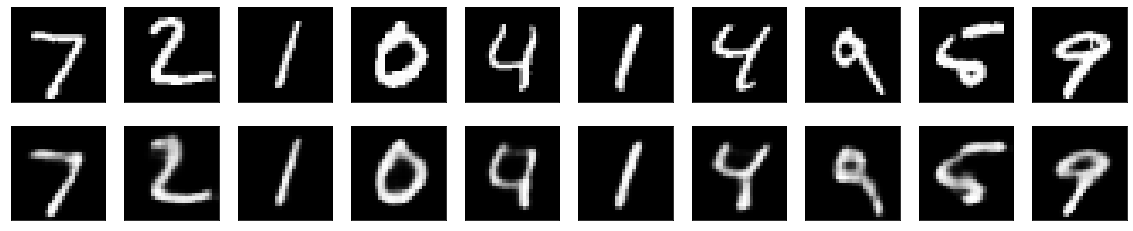

In [8]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


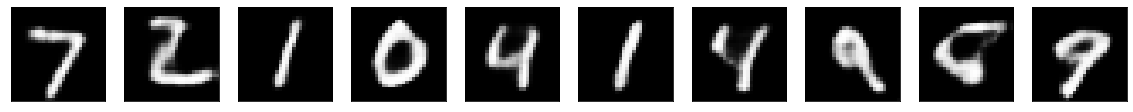

In [11]:
encoded_imgs = autoencoder.predict(x_test)
# encoded representation
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
# extracting only encoder and pulling out the encoded imgs
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

In [20]:
print(encoded_imgs[0].shape)

(4, 4, 8)


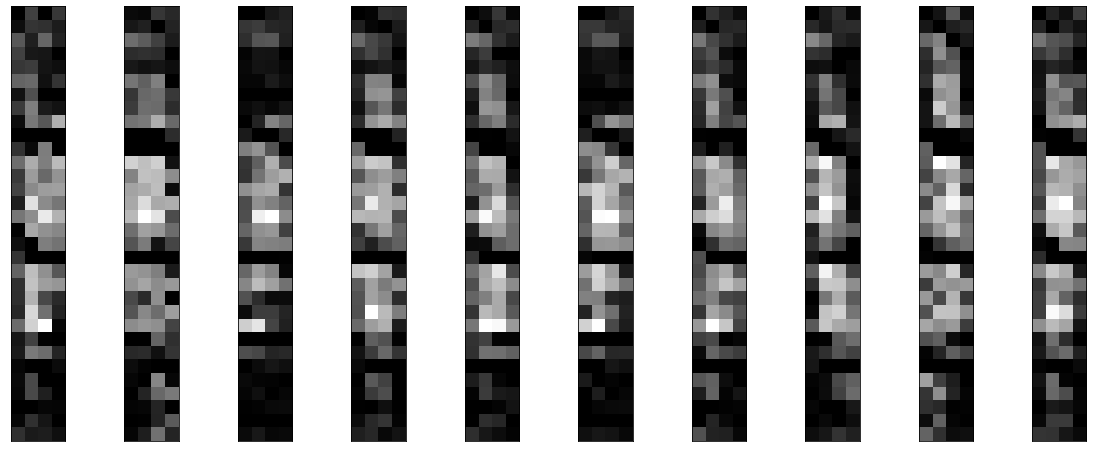

In [21]:
# encoded representation
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    #plt.imshow(encoded_imgs[i].reshape(28,28))
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()